In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
train = pd.read_csv("train_final.csv", index_col=['date'], parse_dates=['date'])
test = pd.read_csv("test_final.csv", index_col=['date'], parse_dates=['date'])

In [ ]:
# drop first 3 months - changes based on presentation recommendation
train = train[~(train.index < '2020-03-01')]
test = test[~(test.index < '2020-03-01')]

In [ ]:
x_train = train.drop(columns = 'new_confirmed')
y_train = train.new_confirmed
x_test = test.drop(columns = 'new_confirmed')
y_test = test.new_confirmed

In [ ]:
train_xgboost = train.drop(columns = ['location_key_x','country_code','season','day_name','Unnamed: 0.1','Unnamed: 0'])
test_xgboost = test.drop(columns = ['location_key_x','country_code','season','day_name','Unnamed: 0.1','Unnamed: 0'])

In [ ]:
# substitutes large numbers for dates without vaccination data - changes based on presentation recommendation
#Condition

train_no_vaccination_check = train_xgboost['new_persons_fully_vaccinated'] == 0
test_no_vaccination_check = test_xgboost['new_persons_fully_vaccinated'] == 0

In [ ]:
train_xgboost.loc[train_no_vaccination_check, 'new_persons_fully_vaccinated'] = 30000
test_xgboost.loc[test_no_vaccination_check, 'new_persons_fully_vaccinated'] = 30000

In [ ]:
def process(df):
    df.insert(1, 'lag1_new_confirmed', df['new_confirmed'].shift(1).fillna(0))
    return df

train_xgboost=process(train_xgboost)
test_xgboost=process(test_xgboost)

In [ ]:
xgboost_x_train = train_xgboost.drop(columns = 'new_confirmed')
xgboost_y_train = train_xgboost.new_confirmed
xgboost_x_test = test_xgboost.drop(columns = 'new_confirmed')
xgboost_y_test = test_xgboost.new_confirmed

In [ ]:
xgboost_model = xgb.XGBRegressor()
xgboost_model.fit(xgboost_x_train,xgboost_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgboost_train_pred=pd.DataFrame(xgboost_model.predict(train_xgboost.drop('new_confirmed', axis=1)), columns=['yhat'], index=train_xgboost.index)
xgboost_train_pred

,yhat
date,
2020-03-01,0.107284
2020-03-02,0.107284
2020-03-03,0.107284
2020-03-04,0.107284
2020-03-05,0.107284
...,...
2021-12-27,2.016755
2021-12-28,2.507581
2021-12-29,0.107284


In [ ]:
# train rmse without tuning
np.sqrt(mean_squared_error(train_xgboost['new_confirmed'],xgboost_train_pred['yhat']))

5.988358467611059

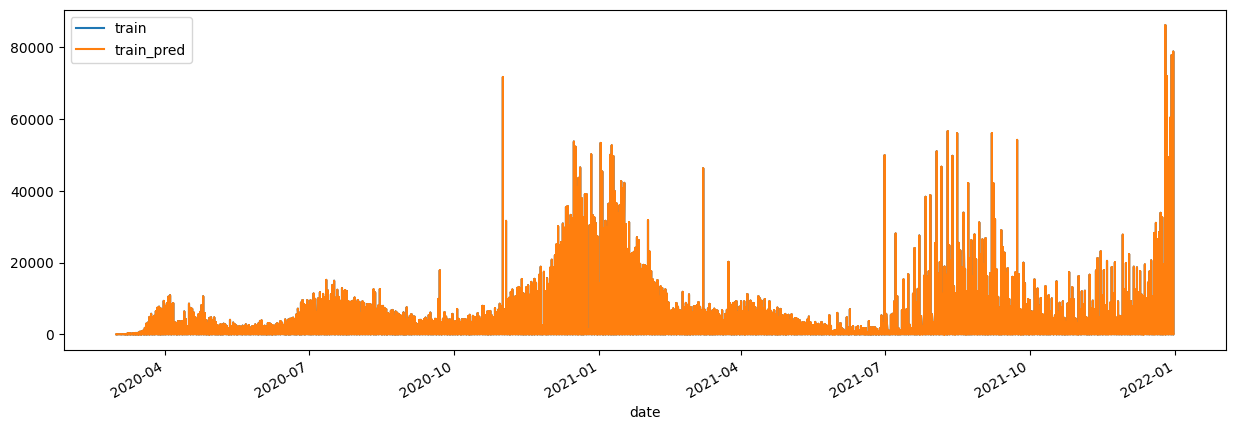

In [ ]:
pd.concat([train_xgboost['new_confirmed'],xgboost_train_pred['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

In [ ]:
# test rmse without tuning
np.sqrt(mean_squared_error(test_xgboost['new_confirmed'],xgboost_test_pred['yhat']))

2018.5864816693672

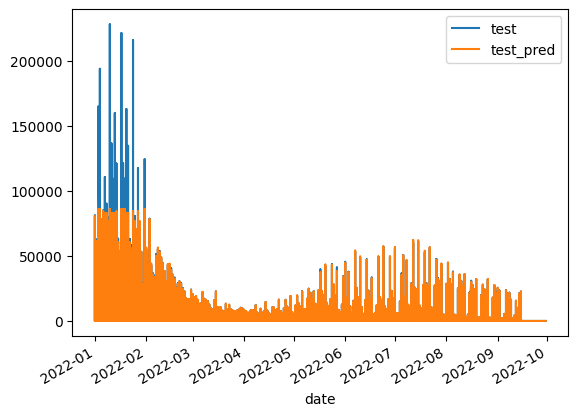

In [ ]:
xgboost_test_pred=pd.DataFrame(xgboost_model.predict(test_xgboost.drop('new_confirmed', axis=1)), columns=['yhat'], index=test_xgboost.index)
pd.concat([test_xgboost['new_confirmed'],xgboost_test_pred['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
param_grid = {'max_depth': [1,5,10],
              'learning_rate': [0.0001,0.1,1],
               'reg_lambda':[0,0.001,0.1,1,10,100],
                'n_estimators':[100,1000,2000,3000],
              'gamma':[0,0.001,0.1,1,10,100],
              'subsample':[0.1,0.25,0.5,1]}

cv = KFold(n_splits=3,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=45),
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)

optimal_params.fit(xgboost_x_train, xgboost_y_train)
print("Optimal parameter values =", optimal_params.best_params_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Optimal parameter values = {'subsample': 1, 'reg_lambda': 100, 'n_estimators': 3000, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 100}


In [ ]:
xgboost_model2 = xgb.XGBRegressor(subsample=1,reg_lambda=100,n_estimators=3000,max_depth=10,learning_rate=0.1,gamma=100)
xgboost_model2.fit(xgboost_x_train,xgboost_y_train)
xgboost_train_pred2=pd.DataFrame(xgboost_model2.predict(train_xgboost.drop('new_confirmed', axis=1)), columns=['yhat'], index=train_xgboost.index)
xgboost_test_pred2=pd.DataFrame(xgboost_model2.predict(test_xgboost.drop('new_confirmed', axis=1)), columns=['yhat'], index=test_xgboost.index)

In [ ]:
#train rmse after tuning
np.sqrt(mean_squared_error(train_xgboost['new_confirmed'],xgboost_train_pred2['yhat']))

4.313233192557407

In [ ]:
#test rmse after tuning
np.sqrt(mean_squared_error(test_xgboost['new_confirmed'],xgboost_test_pred2['yhat']))

1996.9913094199603

In [ ]:
#final tuning

param_grid = {'max_depth': [8,10,15,20],
              'learning_rate': [0.05,0.1,0.15],
               'reg_lambda':[100,300,500],
                'n_estimators':[2000,2500,3000,3500],
              'gamma':[50,75,100],
              'subsample':[0.1,0.25,0.5,1]}

cv = KFold(n_splits=3,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=45),
                             param_distributions = param_grid, n_iter = 100,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv)

optimal_params.fit(xgboost_x_train, xgboost_y_train)
print("Optimal parameter values =", optimal_params.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Optimal parameter values = {'subsample': 1, 'reg_lambda': 100, 'n_estimators': 3500, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 100}


In [ ]:
xgboost_model_final = xgb.XGBRegressor(subsample=1,reg_lambda=100,n_estimators=3500,max_depth=8,learning_rate=0.1,gamma=100)
xgboost_model_final.fit(xgboost_x_train,xgboost_y_train)
xgboost_train_pred_final=pd.DataFrame(xgboost_model_final.predict(train_xgboost.drop('new_confirmed', axis=1)), columns=['yhat'], index=train_xgboost.index)
xgboost_test_pred_final=pd.DataFrame(xgboost_model_final.predict(test_xgboost.drop('new_confirmed', axis=1)), columns=['yhat'], index=test_xgboost.index)

In [ ]:
#train rmse after final tuning
np.sqrt(mean_squared_error(train_xgboost['new_confirmed'],xgboost_train_pred_final['yhat']))

3.76068317511823

In [ ]:
#test rmse after final tuning
np.sqrt(mean_squared_error(test_xgboost['new_confirmed'],xgboost_test_pred_final['yhat']))

1989.49074067982

In [ ]:
xgboost_model_final = xgb.XGBRegressor(subsample=1,reg_lambda=100,n_estimators=3500,max_depth=8,learning_rate=0.1,gamma=100)
xgboost_model_final.fit(xgboost_x_train,xgboost_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=100, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

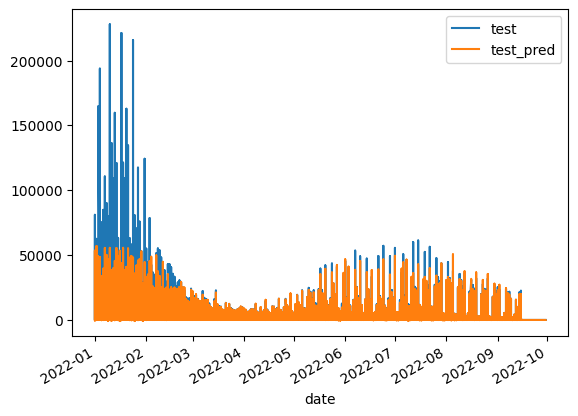

In [ ]:
xgboost_test_pred_final=pd.DataFrame(xgboost_model_final.predict(test_xgboost.drop('new_confirmed', axis=1)), columns=['yhat'], index=test_xgboost.index)
pd.concat([test_xgboost['new_confirmed'],xgboost_test_pred_final['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [ ]:
xgboost_model_final.get_booster().get_score(importance_type="gain")

{'new_deceased': 249313.015625,
 'lag1_new_confirmed': 1448375.25,
 'cumulative_deceased': 204182.765625,
 'population': 476449.875,
 'population_male': 200482.375,
 'population_female': 2925.449951171875,
 'latitude': 563412.875,
 'longitude': 180802.859375,
 'area_sq_km': 245462.5,
 'life_expectancy': 1404331.25,
 'mobility_workplaces': 117134.3359375,
 'new_persons_fully_vaccinated': 609678.1875,
 'cumulative_persons_fully_vaccinated': 562069.75,
 'gdp_per_capita_usd': 415.9486389160156,
 'AG.LND.AGRI.ZS': 531.09375,
 'AG.LND.ARBL.ZS': 176.73095703125,
 'EN.ATM.PM25.MC.ZS': 392.408203125,
 'ER.FSH.CAPT.MT': 434.05078125,
 'new_confirmed_lag1': 990450.3125,
 'new_confirmed_lag3': 273766.6875,
 'new_confirmed_lag7': 787400.3125,
 'new_confirmed_mean1': 151751696.0,
 'new_confirmed_mean3': 822292.3125,
 'new_confirmed_mean7': 547116.375,
 'new_confirmed_std3': 553624.625,
 'new_confirmed_std7': 2111227.5,
 'new_confirmed_max3': 1757543.125,
 'new_confirmed_max7': 5291156.5,
 'new_confi